In [ ]:
!pip install inference-sdk pillow matplotlib requests
!pip install geojson pandas numpy ipywidgets
!pip install -q roboflow pycocotools torchvision

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import json
import pandas as pd
import geojson
from datetime import datetime
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.12.15
    Uninstalling aiohttp-3.12.15:
      Successfully uninstalled aiohttp-3.12.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [ ]:
from inference_sdk import InferenceHTTPClient

# Initialize client - REPLACE WITH YOUR API KEY
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="Ch9ff7lRKZ2Yu546Wz3E"  # ← Replace with your actual API key
)

# Your model ID - REPLACE WITH YOUR MODEL ID
MODEL_ID = "building-detection-dn7vv-hpdll/2"  # ← Replace with your tree detection model ID

print("✅ Roboflow Inference client initialized!")
print(f"Model ID: {MODEL_ID}")

✅ Roboflow Inference client initialized!
Model ID: building-detection-dn7vv-hpdll/2


In [ ]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.7 MB/s eta 0:00:00


In [ ]:
def _clamp_threshold(th):
    # Hard-limit to [0.1, 0.5]
    return float(np.clip(th, 0.1, 0.5))

def detect_trees(image_path, confidence_threshold=0.5, overlap=0.5):
    confidence_threshold = _validate_threshold(confidence_threshold)
    overlap = float(np.clip(overlap, 0.0, 1.0))

    # Append query params to model_id (works across SDK versions)
    model_with_params = f"{MODEL_ID}?confidence={confidence_threshold}&overlap={overlap}"

    print(
        f"🔍 Detecting trees in: {image_path} "
        f"(server min conf={confidence_threshold:.2f}, nms overlap={overlap:.2f})"
    )

    try:
        result = CLIENT.infer(image_path, model_id=model_with_params)
        print("✅ Inference completed successfully!")
        return result
    except Exception as e:
        print(f"❌ Error during inference: {e}")
        return None


def filter_detections(result, confidence_threshold=0.5):
    confidence_threshold = _validate_threshold(confidence_threshold)
    if not result or 'predictions' not in result:
        return []
    filtered = [pred for pred in result['predictions']
                if pred.get('confidence', 0.0) >= confidence_threshold]
    print(f"📊 Found {len(filtered)} trees (confidence ≥ {confidence_threshold:.2f})")
    return filtered

def _validate_threshold(th):
    th = float(th)
    if th < 0.0: th = 0.0
    if th > 1.0: th = 1.0
    return th


def calculate_center_coordinates(predictions):
    """
    Calculate center points of all bounding boxes.
    NOTE: Roboflow already provides centers as pred['x'], pred['y'].
    """
    center_points = []
    for p in predictions:
        cx, cy = float(p['x']), float(p['y'])
        w, h = float(p['width']), float(p['height'])
        center_points.append({
            'center_x': round(cx, 2),         # already center
            'center_y': round(cy, 2),         # already center
            'bbox_x_center': cx,
            'bbox_y_center': cy,
            'bbox_width': w,
            'bbox_height': h,
            'confidence': float(p['confidence']),
            'class': p.get('class', ''),
            'class_id': p.get('class_id', -1),
            'detection_id': p.get('detection_id', ''),
            'area': w * h
        })
    return center_points

def _center_to_topleft_box(pred):
    """
    Convert Roboflow center-format bbox to top-left format for drawing:
      input: {'x': cx, 'y': cy, 'width': w, 'height': h}
      output: (x_min, y_min, w, h)
    """
    cx, cy = float(pred['x']), float(pred['y'])
    w, h = float(pred['width']), float(pred['height'])
    x_min = cx - w / 2.0
    y_min = cy - h / 2.0
    return x_min, y_min, w, h

def visualize_detections(image, predictions, center_points):
    # Use the original image in its native size (no resizing before drawing)
    image_np = np.array(image)  # RGB
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    for pred, center in zip(predictions, center_points):
        x_min, y_min, w, h = _center_to_topleft_box(pred)

        # Safe integer conversion for drawing
        x1, y1, x2, y2 = int(round(x_min)), int(round(y_min)), int(round(x_min + w)), int(round(y_min + h))
        cx_i, cy_i = int(round(center['center_x'])), int(round(center['center_y']))

        # Draw bbox (green) and center (blue)
        cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.circle(image_np, (cx_i, cy_i), 6, (255, 0, 0), -1)

        label = f"{pred.get('class','tree')} {pred['confidence']:.2f}"
        cv2.putText(image_np, label, (x1, max(0, y1 - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))
    plt.imshow(image_rgb)
    plt.title(f"Tree Detection Results: {len(predictions)} Trees Found", fontsize=16, weight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def export_results(center_points, predictions, output_dir="results"):
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    json_data = {
        "metadata": {
            "export_date": datetime.now().isoformat(),
            "total_detections": len(center_points),
            "model_id": MODEL_ID,
            "coordinates_type": "pixel_coordinates_center_based"  # clarify format origin
        },
        "detections": center_points,
        "raw_predictions": predictions
    }

    json_file = os.path.join(output_dir, f"tree_detections_{timestamp}.json")
    with open(json_file, 'w') as f:
        json.dump(json_data, f, indent=2)

    csv_file = os.path.join(output_dir, f"tree_centers_{timestamp}.csv")
    pd.DataFrame(center_points).to_csv(csv_file, index=False)

    print(f"✅ Results exported to:\n   JSON: {json_file}\n   CSV: {csv_file}")
    return json_file, csv_file

def run_complete_pipeline(image_path, confidence_threshold=0.30, overlap=0.5):
    confidence_threshold = _validate_threshold(confidence_threshold)
    print("🚀 Starting Tree Detection Pipeline")
    print("=" * 50)

    result = detect_trees(
        image_path,
        confidence_threshold=confidence_threshold,
        overlap=overlap
    )
    if not result:
        return

    # Optional second gate (can keep it equal to the server threshold)
    predictions = filter_detections(result, confidence_threshold)

    if not predictions:
        print("❌ No trees detected above confidence threshold")
        return

    center_points = calculate_center_coordinates(predictions)

    # IMPORTANT: open & display the ORIGINAL image (no resizing) to align with pixel coords
    image = Image.open(image_path).convert("RGB")
    visualize_detections(image, predictions, center_points)

    json_file, csv_file = export_results(center_points, predictions)

    confidences = [float(p['confidence']) for p in predictions]
    print("\n📊 Detection Summary:")
    print(f"   Total trees detected: {len(predictions)}")
    print(f"   Average confidence: {np.mean(confidences):.3f}")
    print(f"   Confidence range: {np.min(confidences):.3f} - {np.max(confidences):.3f}")

    return center_points, predictions


📤 Click 'Choose Files' and select your image:


Saving Google_Map_Image_0_8.jpeg to Google_Map_Image_0_8 (1).jpeg
✅ Uploaded: Google_Map_Image_0_8 (1).jpeg


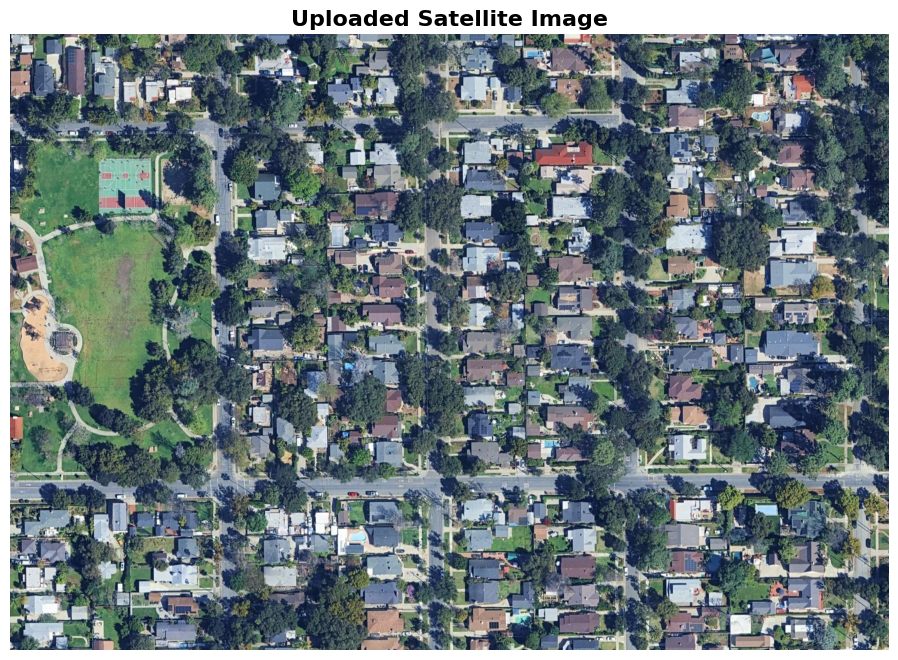

FloatSlider(value=0.4, continuous_update=False, description='Min conf:', max=0.5, min=0.1, step=0.05)

Button(button_style='primary', description='Run Detection', style=ButtonStyle())

Output()

In [ ]:
from google.colab import files

print("📤 Click 'Choose Files' and select your image:")
uploaded = files.upload()

if uploaded:
    image_path = list(uploaded.keys())[0]
    print(f"✅ Uploaded: {image_path}")

    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title("Uploaded Satellite Image", fontsize=16, weight='bold')
    plt.axis('off')
    plt.show()

# After you've set image_path via files.upload()...
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    slider = widgets.FloatSlider(
        value=0.40, min=0.10, max=0.50, step=0.05,
        description='Min conf:',
        readout_format='.2f', continuous_update=False
    )

    run_button = widgets.Button(description="Run Detection", button_style='primary')
    out = widgets.Output()

    def _on_click(_):
        with out:
            clear_output(wait=True)
            run_complete_pipeline(image_path, confidence_threshold=slider.value)

    run_button.on_click(_on_click)
    display(slider, run_button, out)

except Exception as e:
    print("Widgets not available, falling back to direct call.")
    # Fallback single call:
    results = run_complete_pipeline(image_path, confidence_threshold=0.30)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="Ch9ff7lRKZ2Yu546Wz3E")  # <— put your key here
project = rf.workspace("tanmmay-koli").project("building-detection-dn7vv-hpdll")
dataset = project.version(2).download("coco")

import os
from torchvision.datasets import CocoDetection

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TEST_DIRECTORY = os.path.join(dataset.location, "test")

# Create a torchvision CocoDetection dataset
TEST_DATASET = CocoDetection(
    root=TEST_DIRECTORY,
    annFile=os.path.join(TEST_DIRECTORY, ANNOTATION_FILE_NAME)
)

print("✅ Test set ready:", len(TEST_DATASET), "images")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to building-detection-2 in coco:: 100%|██████████| 536/536 [00:00<00:00, 3759.01it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
✅ Test set ready: 22 images


In [ ]:
import os, json, time
from pathlib import Path
from tqdm import tqdm
import numpy as np
from pycocotools.coco import COCO

# --- config ---
RF_CONF = 0.10        # keep this LOW so we don't lose low-score preds (COCOeval uses scores to rank)
RF_NMS  = 0.5         # overlap (IoU) used server-side by RF
SLEEP_BETWEEN = 0.05  # tiny delay to be nice to the API

# COCO class-name ↔ id map from your test set
coco_gt: COCO = TEST_DATASET.coco
name2coco = {v['name']: k for k, v in coco_gt.cats.items()}

def rf_to_coco_bbox(pred):
    """RF center-format -> COCO [x,y,w,h] (top-left)."""
    cx, cy = float(pred["x"]), float(pred["y"])
    w, h   = float(pred["width"]), float(pred["height"])
    x_min  = cx - w/2.0
    y_min  = cy - h/2.0
    return [x_min, y_min, w, h]

def run_rf_on_testset(conf=RF_CONF, overlap=RF_NMS, max_images=None):
    """
    Returns: list of COCO result dicts for all test images.
    """
    image_ids = coco_gt.getImgIds()
    if max_images is not None:
        image_ids = image_ids[:int(max_images)]

    results = []

    for img_id in tqdm(image_ids, desc="Roboflow inference on test set"):
        info = coco_gt.loadImgs(img_id)[0]
        img_path = os.path.join(TEST_DATASET.root, info["file_name"])
        assert os.path.exists(img_path), img_path

        # Pass params in the model_id query so SDK preserves them
        model_with_params = f"{MODEL_ID}?confidence={conf:.2f}&overlap={overlap:.2f}"
        try:
            out = CLIENT.infer(img_path, model_id=model_with_params)
        except Exception as e:
            print(f"[warn] RF error on {info['file_name']}: {e}")
            time.sleep(0.5)
            continue

        preds = out.get("predictions", [])
        for p in preds:
            cls_name = p.get("class", None)
            if cls_name is None or cls_name not in name2coco:
                # skip unknown class names
                continue
            coco_cat_id = int(name2coco[cls_name])
            results.append({
                "image_id": int(img_id),
                "category_id": coco_cat_id,
                "bbox": rf_to_coco_bbox(p),
                "score": float(p.get("confidence", 0.0)),
            })

        time.sleep(SLEEP_BETWEEN)

    return results

# Run and cache
rf_coco_results = run_rf_on_testset(conf=RF_CONF, overlap=RF_NMS)
os.makedirs("/content/rf_eval", exist_ok=True)
rf_pred_json = "/content/rf_eval/rf_predictions_coco.json"
with open(rf_pred_json, "w") as f:
    json.dump(rf_coco_results, f)
print(f"Saved {len(rf_coco_results)} predictions to {rf_pred_json}")


Roboflow inference on test set: 100%|██████████| 22/22 [00:44<00:00,  2.04s/it]

Saved 922 predictions to /content/rf_eval/rf_predictions_coco.json


In [ ]:
from pycocotools.cocoeval import COCOeval
import json

# Load GT and predictions
coco_gt = TEST_DATASET.coco
with open(rf_pred_json, "r") as f:
    preds_list = json.load(f)

# pycocotools wants a COCO-format results object
coco_dt = coco_gt.loadRes(preds_list) if len(preds_list) else coco_gt.loadRes([])

# Run COCO evaluation (bbox)
coco_eval = COCOeval(cocoGt=coco_gt, cocoDt=coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()  # prints the same table format you saw for your local model


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# Build preds/GT dicts for sweeping confidence thresholds (IoU-based matching)

import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict
from pycocotools.coco import COCO

# 1) Load RF predictions (COCO-format list with keys: image_id, category_id, bbox [x,y,w,h], score)
try:
    rf_coco_results  # variable exists from earlier
    preds_list = rf_coco_results
except NameError:
    # fall back to JSON file path saved earlier
    try:
        rf_pred_json
    except NameError:
        rf_pred_json = "/content/rf_eval/rf_predictions_coco.json"  # update if you saved elsewhere
    with open(rf_pred_json, "r") as f:
        preds_list = json.load(f)

print(f"Loaded {len(preds_list)} RF predictions")

# 2) Build ground truth (GT) from TEST_DATASET
coco_gt: COCO = TEST_DATASET.coco

# Map: image_id -> list of GT objs: {"bbox": [x,y,w,h], "cat": category_id}
gt_by_img = defaultdict(list)
for ann in coco_gt.anns.values():
    if ann.get("iscrowd", 0) == 1:
        continue
    x, y, w, h = ann["bbox"]
    if w <= 0 or h <= 0:
        continue
    gt_by_img[ann["image_id"]].append({
        "bbox": [float(x), float(y), float(w), float(h)],
        "cat": int(ann["category_id"])
    })

# 3) Group predictions per image
preds_by_img = defaultdict(list)
for p in preds_list:
    x, y, w, h = p["bbox"]
    preds_by_img[int(p["image_id"])].append({
        "bbox": [float(x), float(y), float(w), float(h)],
        "cat": int(p["category_id"]),
        "score": float(p["score"])
    })

print(f"GT images with anns: {len(gt_by_img)}")
print(f"Images with preds  : {len(preds_by_img)}")

# 4) IoU util for xywh
def iou_xywh(a, b):
    ax1, ay1, ax2, ay2 = a[0], a[1], a[0]+a[2], a[1]+a[3]
    bx1, by1, bx2, by2 = b[0], b[1], b[0]+b[2], b[1]+b[3]
    inter = max(0, min(ax2, bx2) - max(ax1, bx1)) * max(0, min(ay2, by2) - max(ay1, by1))
    union = max(1e-12, a[2]*a[3] + b[2]*b[3] - inter)
    return inter / union


Loaded 922 RF predictions
GT images with anns: 22
Images with preds  : 22


    conf  precision  recall     f1   tp   fp   fn
0   0.05      0.304   0.878  0.451  280  642   39
1   0.10      0.304   0.878  0.451  280  642   39
2   0.15      0.453   0.840  0.588  268  324   51
3   0.20      0.588   0.787  0.673  251  176   68
4   0.25      0.649   0.752  0.697  240  130   79
5   0.30      0.718   0.727  0.723  232   91   87
6   0.35      0.757   0.712  0.733  227   73   92
7   0.40      0.814   0.674  0.738  215   49  104
8   0.45      0.844   0.646  0.732  206   38  113
9   0.50      0.878   0.633  0.736  202   28  117
10  0.55      0.887   0.618  0.728  197   25  122
11  0.60      0.901   0.599  0.719  191   21  128
12  0.65      0.923   0.564  0.700  180   15  139
13  0.70      0.945   0.539  0.687  172   10  147
14  0.75      0.970   0.505  0.664  161    5  158
15  0.80      0.992   0.398  0.568  127    1  192
16  0.85      0.985   0.210  0.346   67    1  252
17  0.90      1.000   0.041  0.078   13    0  306
18  0.95      0.000   0.000  0.000    0    0  319


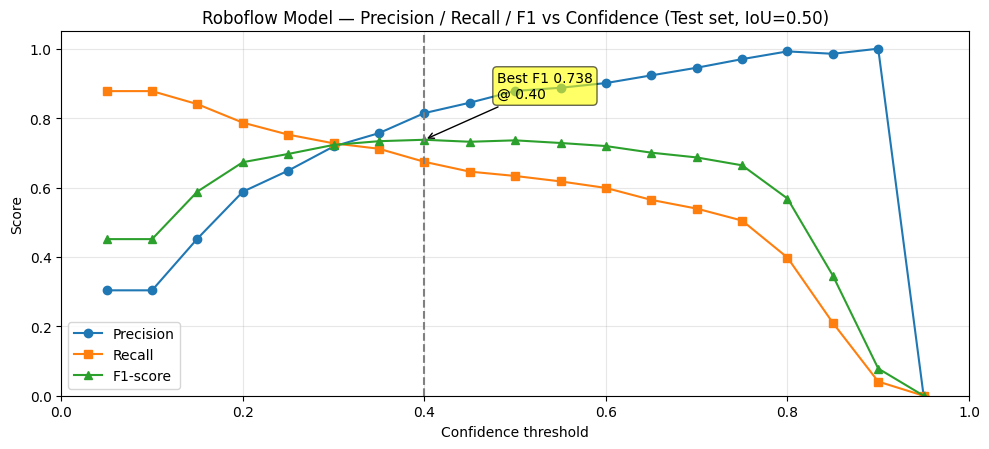

In [ ]:
# Sweep confidence thresholds and compute Precision / Recall / F1 (IoU=0.50)

import numpy as np, pandas as pd, matplotlib.pyplot as plt

IOU_THRESH = 0.50
THRESHOLDS = np.round(np.linspace(0.05, 0.95, 19), 2)

rows = []
all_img_ids = set(gt_by_img.keys())  # evaluate over images that have GT

for th in THRESHOLDS:
    TP = FP = FN = 0
    for img_id in all_img_ids:
        gts = gt_by_img.get(img_id, [])
        used = [False] * len(gts)

        cand = [p for p in preds_by_img.get(img_id, []) if p["score"] >= float(th)]
        cand.sort(key=lambda x: x["score"], reverse=True)

        for p in cand:
            best_iou, best_j = 0.0, -1
            for j, g in enumerate(gts):
                if used[j] or p["cat"] != g["cat"]:
                    continue
                iou = iou_xywh(p["bbox"], g["bbox"])
                if iou > best_iou:
                    best_iou, best_j = iou, j
            if best_iou >= IOU_THRESH and best_j >= 0:
                used[best_j] = True
                TP += 1
            else:
                FP += 1
        FN += used.count(False)

    P = TP/(TP+FP) if (TP+FP) else 0.0
    R = TP/(TP+FN) if (TP+FN) else 0.0
    F1 = 2*P*R/(P+R+1e-12)
    rows.append({"conf": float(th), "precision": P, "recall": R, "f1": F1,
                 "tp": TP, "fp": FP, "fn": FN})

df = pd.DataFrame(rows)
best = df.loc[df["f1"].idxmax()]
print(df.round(3))
print(f"\nBest F1 = {best.f1:.3f} at confidence {best.conf:.2f} "
      f"(P={best.precision:.3f}, R={best.recall:.3f})")

# Save CSV for slides/appendix
df.to_csv("rf_f1_vs_confidence.csv", index=False)

# Plot
plt.figure(figsize=(10, 4.6))
plt.plot(df["conf"], df["precision"], marker="o", label="Precision")
plt.plot(df["conf"], df["recall"],    marker="s", label="Recall")
plt.plot(df["conf"], df["f1"],        marker="^", label="F1-score")
plt.axvline(best.conf, color="gray", linestyle="--")
plt.annotate(f"Best F1 {best.f1:.3f}\n@ {best.conf:.2f}",
             xy=(best.conf, best.f1),
             xytext=(min(0.95, best.conf+0.08), min(1.0, best.f1+0.12)),
             bbox=dict(boxstyle="round", fc="yellow", alpha=0.6),
             arrowprops=dict(arrowstyle="->"))
plt.title("Roboflow Model — Precision / Recall / F1 vs Confidence (Test set, IoU=0.50)")
plt.xlabel("Confidence threshold"); plt.ylabel("Score")
plt.ylim(0, 1.05); plt.xlim(0, 1.0)
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("rf_precision_recall_f1_vs_conf.png", dpi=220)
print("Saved: rf_f1_vs_confidence.csv, rf_precision_recall_f1_vs_conf.png")


In [ ]:
from google.colab import files
files.download("rf_precision_recall_f1_vs_conf.png")
files.download("rf_f1_vs_confidence.csv")


In [ ]:
def plot_metrics(predictions):
    """Plot metrics like confidence distribution and bbox area"""
    if not predictions:
        print("❌ No predictions to plot metrics.")
        return

    confidences = [p['confidence'] for p in predictions]
    areas = [p['width'] * p['height'] for p in predictions]

    plt.figure(figsize=(15, 5))

    # Confidence histogram
    plt.subplot(1, 2, 1)
    plt.hist(confidences, bins=10, color="skyblue", edgecolor="black")
    plt.title("Confidence Score Distribution")
    plt.xlabel("Confidence")
    plt.ylabel("Count")

    # Area histogram
    plt.subplot(1, 2, 2)
    plt.hist(areas, bins=10, color="lightgreen", edgecolor="black")
    plt.title("Bounding Box Area Distribution")
    plt.xlabel("Area (pixels^2)")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

In [ ]:
if results:
    _, predictions = results
    plot_metrics(predictions)

NameError: name 'results' is not defined